# Estimating the Alfven Mach Number ($M_A$)
## Method 1: Sampling radial $V_{CME}$ from the EUV images and $V_A$ from the MAS model

In [120]:
import warnings
warnings.filterwarnings('ignore')
import logging
import sunpy
sunpy.log.setLevel(logging.WARNING) # Set SunPy's logger to only show WARNING or above

import os
import glob
import numpy as np
import pandas as pd
from datetime import datetime
import sunpy
from sunpy.map import Map
from sunpy.coordinates import sun
from sunpy.coordinates import frames
from sunpy.coordinates import SphericalScreen
from sunpy.sun import constants as const
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import astropy.units as u
import astropy.io.fits as fits
import astropy.constants as astro_const
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, LogStretch, PercentileInterval

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'

### Load SUVI images

In [2]:
suvi_map_objects  = myfuncs.load_suvi(data_dir=data_dir,
                                      start='2024-05-14T17:00:00',
                                      end='2024-05-14T18:00:00',
                                      channel=195)                  # load SUVI data files
clean_suvi_maps   = myfuncs.remove_redundant_maps(suvi_map_objects) # remove redundant images
suvi_seq_runratio = myfuncs.apply_runratio(clean_suvi_maps)         # make running ratio maps

for m in suvi_seq_runratio:
    m.plot_settings['norm'] = colors.Normalize(vmin=0.7, vmax=1.3)  # normalize the intensity range

SUVI image 0 is done
SUVI image 1 is done
SUVI image 2 is done
SUVI image 3 is done
SUVI image 4 is done
SUVI image 5 is done
SUVI image 6 is done
SUVI image 7 is done
SUVI image 8 is done
SUVI image 9 is done
SUVI image 10 is done
SUVI image 11 is done
SUVI image 12 is done
SUVI image 13 is done
SUVI image 14 is done
SUVI image 15 is done
SUVI image 16 is done
SUVI image 17 is done
SUVI image 18 is done
SUVI image 19 is done
SUVI image 20 is done
SUVI image 21 is done


### Preview map

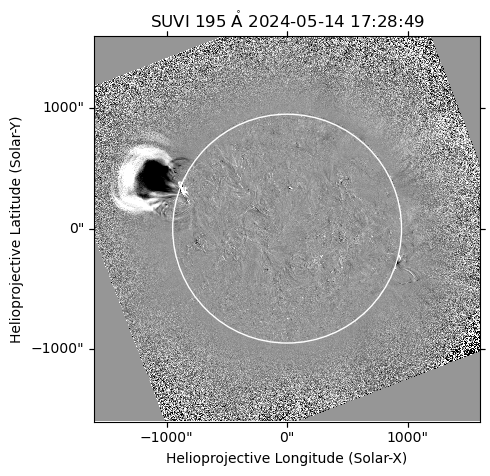

In [6]:
m = suvi_seq_runratio[6]

fig = plt.figure(figsize=[5,5])
ax  = fig.add_subplot(projection=m)
m.plot(axes=ax)
m.draw_limb()
ax.grid(False)
fig.tight_layout()
plt.show()

### Show the radial slits

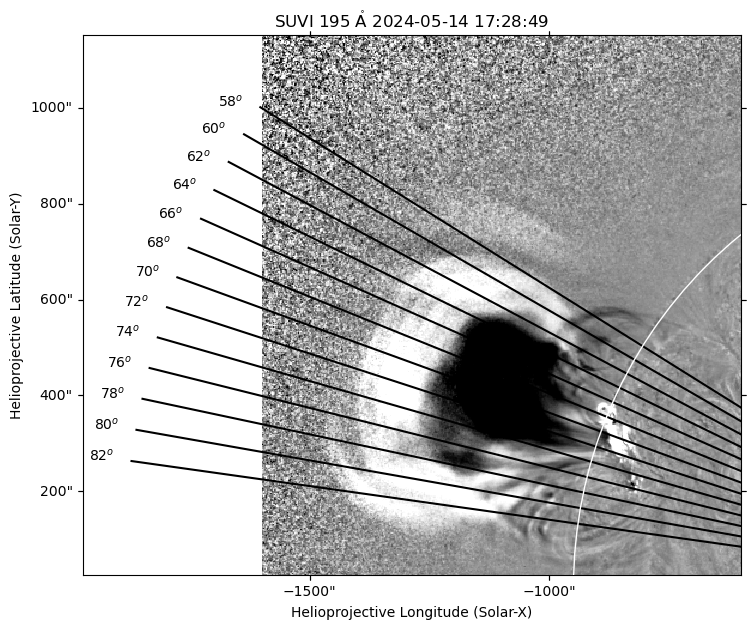

In [10]:
centered_list = myfuncs.generate_centered_list(160, 2, 6)

fig = plt.figure(figsize=[10,7])
ax  = fig.add_subplot(projection=m)
img = m.plot(axes=ax)
m.draw_limb()
ax.grid(False)

for value in centered_list:
    line = myfuncs.plot_line(angle_deg=value, length=1890, map_obj=m)
    ax.plot_coord(line, color='black')
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = m.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=m.coordinate_frame))
    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax.text(end_point_pixel.x.value - 25, end_point_pixel.y.value + 5, f'{PA_value}$^o$',
            color='black', fontsize=10, ha='center', va='center')

ax.set_xlim(left=-150, right=400)
ax.set_ylim(bottom=650, top=1100)
fig.tight_layout()
plt.show()

### Load the pre-estimated radial CME speeds along the slits

In [98]:
suvi_filenames = sorted(glob.glob(f'{data_dir}/jplots/suvi/clicking/*.csv'))
print(len(suvi_filenames), *suvi_filenames, sep='\n')

13
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_148.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_150.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_152.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_154.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_156.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_158.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_160.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_162.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_164.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_166.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_168.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_170.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_172.csv


In [109]:
# print the updated filnames after converting the geometric angles to position angles
updated_filenames = [
    f'{path.rsplit("_", 1)[0]}_{int(path.rsplit("_", 1)[1].replace(".csv", "")) - 90}.csv'
    for path in suvi_filenames
]

print(*updated_filenames, sep='\n')

/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_58.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_60.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_62.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_64.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_66.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_68.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_70.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_72.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_74.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_76.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_78.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_80.csv
/home/mnedal/data/jplots/suvi/clicking/jmap_SUVI 195A_20240514_slit_82.csv


In [115]:
# get the radius of the Sun in km
sun_radius_km = const.radius.to('km').value

all_speeds_suvi  = []
all_accels_suvi  = []
all_times_suvi   = []
all_dists_suvi   = []

for file in suvi_filenames:
    df = pd.read_csv(file)
    df['speed_diff'] = df['speed_km_s'].diff()
    # calculate the Accel. in m/s2
    df['accel_m_s2'] = (df['speed_diff']*1e3) / df['time_diff_s']
    # store all speed and accels.
    all_speeds_suvi.append(df['speed_km_s'].values)
    all_accels_suvi.append(df['accel_m_s2'].values)
    all_times_suvi.append(df['time'].values)
    all_dists_suvi.append(df['distance_km'].values/sun_radius_km)
    # print(f"Max: {np.nanmax(df['distance_km'].values/sun_radius_km):.2f} Rs")
    # print(f"Min: {np.nanmin(df['distance_km'].values/sun_radius_km):.2f} Rs\n")

# Combine the 1D arrays into a single 1D array
combined_array_v = np.concatenate(all_speeds_suvi)
combined_array_a = np.concatenate(all_accels_suvi)
combined_array_t = np.concatenate(all_times_suvi)
combined_array_d = np.concatenate(all_dists_suvi)

# Calculate basic statistics
max_v    = np.nanmax(combined_array_v)
min_v    = np.nanmin(combined_array_v)
mean_v   = np.nanmean(combined_array_v)
median_v = np.nanmedian(combined_array_v)
std_v    = np.nanstd(combined_array_v)
count_v  = combined_array_v.size

max_a    = np.nanmax(combined_array_a)
min_a    = np.nanmin(combined_array_a)
mean_a   = np.nanmean(combined_array_a)
median_a = np.nanmedian(combined_array_a)
std_a    = np.nanstd(combined_array_a)
count_a  = combined_array_a.size

max_d = np.nanmax(combined_array_d)
min_d = np.nanmin(combined_array_d)
print(f"Start height: {min_d:.2f} Rs")
print(f"End height:  {max_d:.2f} Rs")

max_t = datetime.strftime(mdates.num2date(np.nanmax(combined_array_t)), '%Y-%m-%d %H:%M:%S')
min_t = datetime.strftime(mdates.num2date(np.nanmin(combined_array_t)), '%Y-%m-%d %H:%M:%S')
print(f"\nStart time: {min_t}")
print(f"End time:  {max_t}")

Start height: 1.17 Rs
End height:  1.92 Rs

Start time: 2024-05-14 17:12:35
End time:  2024-05-14 17:37:02


In [117]:
df.head()

Unnamed: 0          time     distance     x_err      y_err        x_mean  \
0           0  19857.725537  1300.331516  0.000458  10.956754  19857.725537   
1           1  19857.728332  1409.052134  0.000450   8.732082  19857.728332   
2           2  19857.731091  1572.133061  0.000475   8.807252  19857.731091   

        y_mean   distance_km  distance_diff_km  \
0  1300.331516  9.531440e+05               NaN   
1  1409.052134  1.032836e+06      79692.294450   
2  1572.133061  1.152375e+06     119538.441675   

                           datetime  time_diff_s  speed_km_s  speed_diff  \
0  2024-05-14 17:24:46.389128+00:00          NaN         NaN         NaN   
1  2024-05-14 17:28:47.853300+00:00   241.464172  330.037760         NaN   
2  2024-05-14 17:32:46.268682+00:00   238.415382  501.387287  171.349527   

   accel_m_s2  
0         NaN  
1         NaN  
2  718.701646

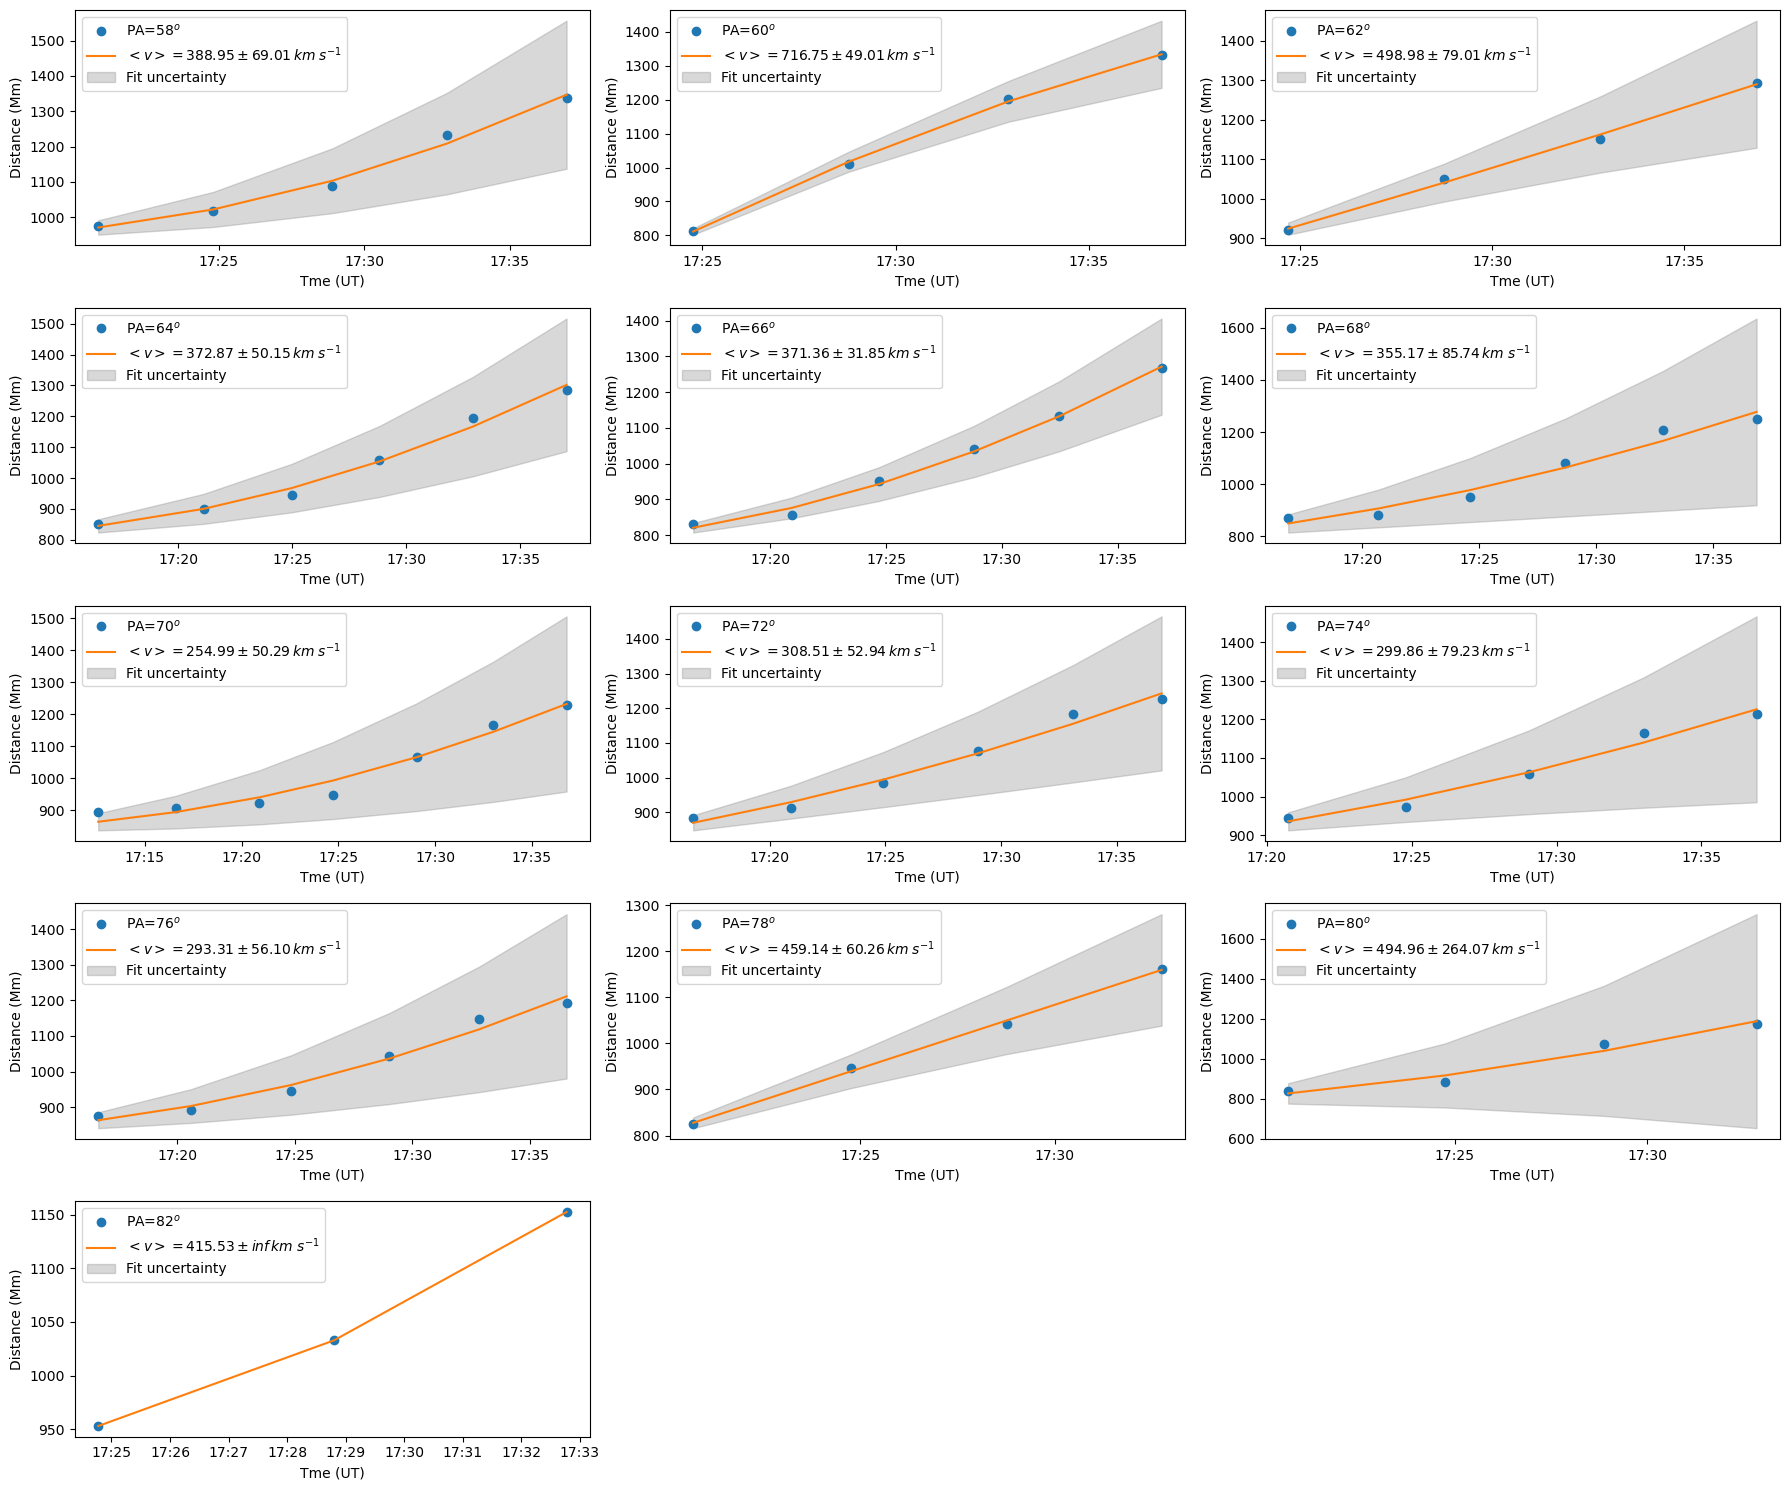

In [128]:
# Initialize an empty list to store results
fit_results_suvi     = []
all_times_suvi       = []
all_speeds_km_s_suvi = []
all_speed_errors     = []
all_accels_m_s2_suvi = []
all_fit_dist_Mm_suvi = []

num_files = len(suvi_filenames)
cols = 3                                             # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()                                       # Flatten in case of a 2D array of axes

for i, file in enumerate(suvi_filenames):
    df = pd.read_csv(file)
    
    angle = file.split('_')[-1][:-4]
    # rename the angles to be position angles, instead of geometric angles
    PA_value = int(angle) - 90
    
    # calc speed via savgol filter, in km/s
    x    = df['time']
    y    = df['distance_km']
    y_Mm = [(y_km*u.km).to('Mm').value for y_km in y]
    
    # apply the kinematic fit
    # ========================
    time_array = np.array([mdates.num2date(xtime) for xtime in x], dtype='datetime64[ms]')  # Use milliseconds for precision
    # Convert datetime array to seconds starting from zero
    time = (time_array - time_array[0]) / np.timedelta64(1, 's')  # Convert to seconds
    
    # Apply the fit to each segment
    fitted, velocity, velocity_err, acceleration, s0, v0, a, init_pos_err, init_vel_err, a_err = myfuncs.fit_kinematics(time, y_Mm, d1=1, d2=2)
    # Calculate upper and lower bounds using parameter errors
    fitted_distance_upper = myfuncs.kinematic_model(time, s0+init_pos_err, v0+init_vel_err, a+a_err)
    fitted_distance_lower = myfuncs.kinematic_model(time, s0-init_pos_err, v0-init_vel_err, a-a_err)
    
    # Convert units to desired formats
    velocity     *= 1_000         # Convert velocity from Mm/s to km/s
    velocity_err *= 1_000         # Convert velocity from Mm/s to km/s
    v0           *= 1_000         # Convert velocity from Mm/s to km/s
    init_vel_err *= 1_000         # Convert velocity error from Mm/s to km/s
    a     *= 1_000                # Convert acceleration from Mm/s² to km/s²
    a_err *= 1_000                # Convert acceleration error from Mm/s² to km/s²
    
    # Estimate velocities
    t_start = time[0]
    t_end   = time[-1]
    # Minimum velocity (at t_start)
    v_min     = v0 + a*t_start
    v_min_err = np.sqrt(init_vel_err**2 + (t_start*a_err)**2)
    # Maximum velocity (at t_end)
    v_max     = v0 + a*t_end
    v_max_err = np.sqrt(init_vel_err**2 + (t_end*a_err)**2)
    v_mean     = np.nanmean(velocity)
    v_mean_err = np.sqrt(np.nansum(velocity_err**2)) / len(velocity)
    # Convert units to desired formats
    a     *= 1_000                # Convert acceleration from km/s² to m/s²
    a_err *= 1_000                # Convert acceleration error from km/s² to m/s²
    acceleration *= 1_000_000     # Convert acceleration from Mm/s² to m/s²
    
    # store all speed and accels. --> Why am I doing this? --> To get the overall distribution of each variable
    all_times_suvi.append(time_array)
    all_speeds_km_s_suvi.append(velocity)
    all_speed_errors.append(velocity_err)
    all_accels_m_s2_suvi.append(acceleration)
    all_fit_dist_Mm_suvi.append(fitted)
    
    # Store results as a dictionary
    fit_results_suvi.append({
        'PA': PA_value,
        's0_Mm': s0,
        'v0_km/s': v0,
        'a_m/s2': a,
        'v_min_km/s': v_min,
        'v_max_km/s': v_max,
        'v_mean_km/s': v_mean,
        'init_pos_err_Mm': init_pos_err,
        'init_vel_err_km/s': init_vel_err,
        'a_err_m/s2': a_err,
        'v_min_err_km/s': v_min_err,
        'v_max_err_km/s': v_max_err,
        'v_mean_err_km/s': v_mean_err
    })
    
    ax = axes[i]  # Use the i-th subplot
    ax.plot(x, y_Mm, 'o', label=rf'PA={PA_value}$^o$')
    ax.plot(x, fitted, '-', label=rf'$<v>={v_mean:.2f} \pm {v_mean_err:.2f} \, km \; s^{{-1}}$')
    # Plot error bounds as shaded area
    ax.fill_between(x, fitted_distance_lower, fitted_distance_upper, color='gray', alpha=0.3, label='Fit uncertainty')
    ax.set_ylabel('Distance (Mm)')
    ax.set_xlabel('Tme (UT)')
    ax.legend(loc='upper left')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Convert list to DataFrame
fit_df_suvi = pd.DataFrame(fit_results_suvi)
fit_df_suvi = fit_df_suvi.applymap(lambda x: f'{x:.2f}' if isinstance(x, (int, float)) else x)
# Ensure fit_df stays numeric
fit_df_suvi = fit_df_suvi.astype(float)  # Convert all numeric columns back to floats

fig.tight_layout()
plt.show()

In [126]:
fit_df_suvi.head()

PA   s0_Mm  v0_km/s  a_m/s2  v_min_km/s  v_max_km/s  v_mean_km/s  \
0  58.0  970.35   159.37  477.24      159.37      620.26       388.95   
1  60.0  811.58   917.20 -549.74      917.20      517.30       716.75   
2  62.0  924.56   466.69   88.31      466.69      531.30       498.98   
3  64.0  845.36   148.52  359.29      148.52      591.63       372.87   
4  66.0  820.43   176.78  322.29      176.78      567.52       371.36   

   init_pos_err_Mm  init_vel_err_km/s  a_err_m/s2  v_min_err_km/s  \
0            20.39             100.15      199.04          100.15   
1             9.43              62.76      165.54           62.76   
2            15.38             101.41      265.66          101.41   
3            21.55              80.11      124.11           80.11   
4            13.35              51.08       80.84           51.08   

   v_max_err_km/s  v_mean_err_km/s  
0          216.75            69.01  
1          135.80            49.01  
2          219.23            79.01  
3          172.76            50.15  
4          110.52            31.85

In [147]:
# # Sanity check ...
# num_files = len(suvi_filenames)
# cols = 3                                             # Number of columns in the figure
# rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
# bins = 10
# fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
# axes = axes.flatten()  

# for i, (x, y) in enumerate(zip(all_times_suvi, all_fit_dist_Mm_suvi)):
#     ax = axes[i]
#     PA_value = fit_df_suvi['PA'][i]
#     ax.plot(x, y, '--o', label=rf'PA={PA_value}$^o$')
#     ax.set_xlabel('Time (UT)')
#     ax.set_xlabel('Distance (Mm)')
#     ax.legend(loc='upper left')
#     ax.xaxis_date()
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Hide unused subplots if `num_files` is not a multiple of `cols`
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# fig.tight_layout()
# plt.show()

In [148]:
# # Sanity check ...
# num_files = len(suvi_filenames)
# cols = 3                                             # Number of columns in the figure
# rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
# bins = 10
# fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
# axes = axes.flatten()  

# for i, (x, y, err) in enumerate(zip(all_times_suvi, all_speeds_km_s_suvi, all_speed_errors)):
#     ax = axes[i]
#     PA_value = fit_df_suvi['PA'][i]
#     ax.errorbar(x, y, yerr=err, fmt='--o', label=rf'PA={PA_value}$^o$')
#     ax.set_ylabel('Velocity (km/s)')
#     ax.set_xlabel('Tme (UT)')
#     ax.legend(loc='upper left')
#     ax.xaxis_date()
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Hide unused subplots if `num_files` is not a multiple of `cols`
# for j in range(i+1, len(axes)):
#     fig.delaxes(axes[j])

# fig.tight_layout()
# plt.show()

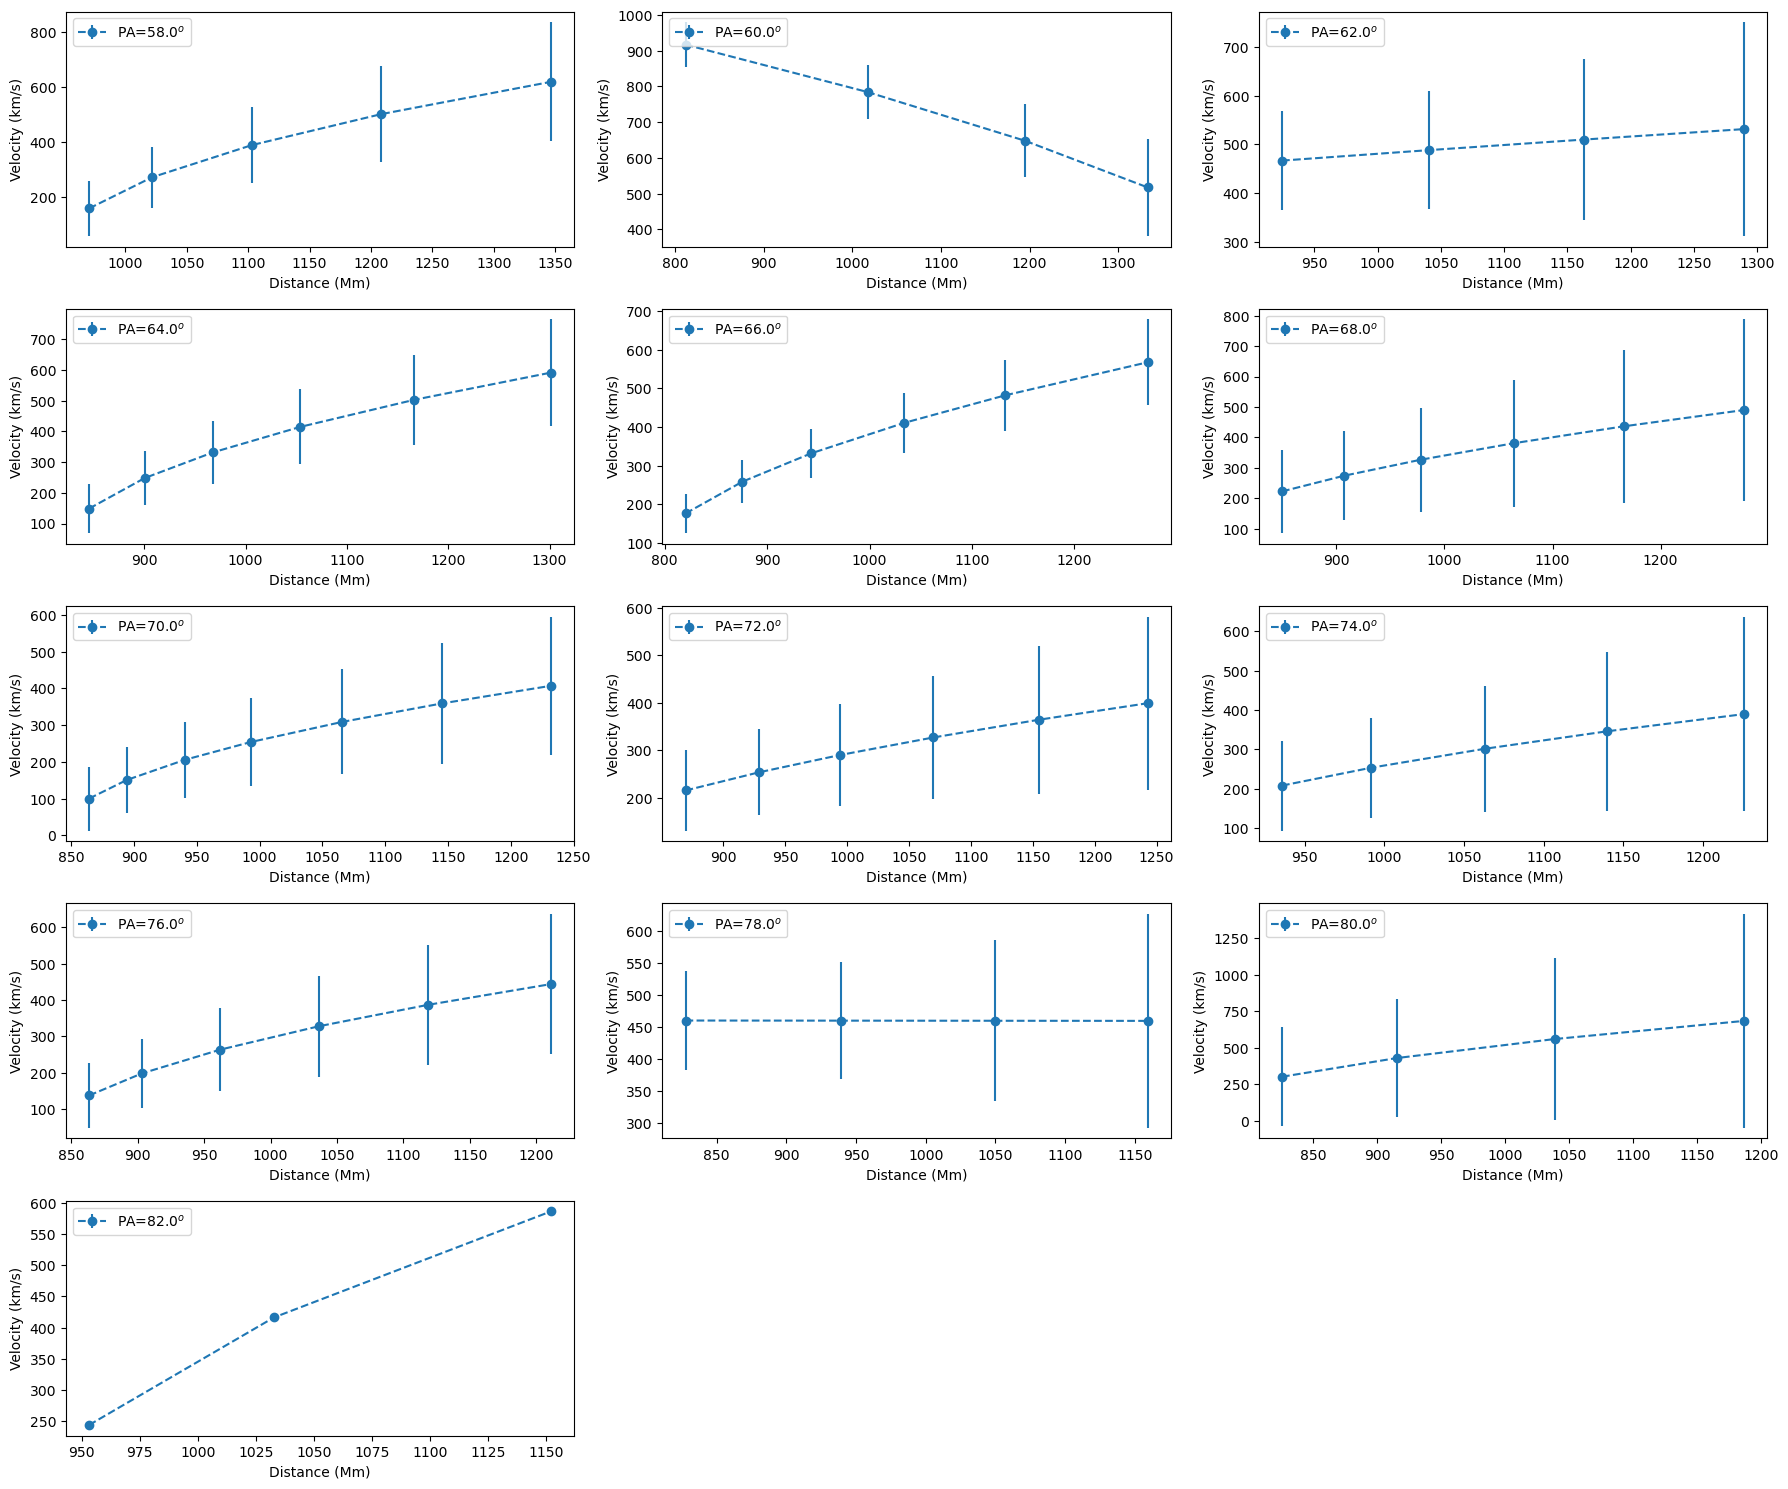

In [141]:
num_files = len(suvi_filenames)
cols = 3                                             # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()  

for i, (x, y, err) in enumerate(zip(all_fit_dist_Mm_suvi, all_speeds_km_s_suvi, all_speed_errors)):
    ax = axes[i]
    PA_value = fit_df_suvi['PA'][i]
    ax.errorbar(x, y, yerr=err, fmt='--o', label=rf'PA={PA_value}$^o$')
    ax.set_ylabel('Velocity (km/s)')
    ax.set_xlabel('Distance (Mm)')
    ax.legend(loc='upper left')

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

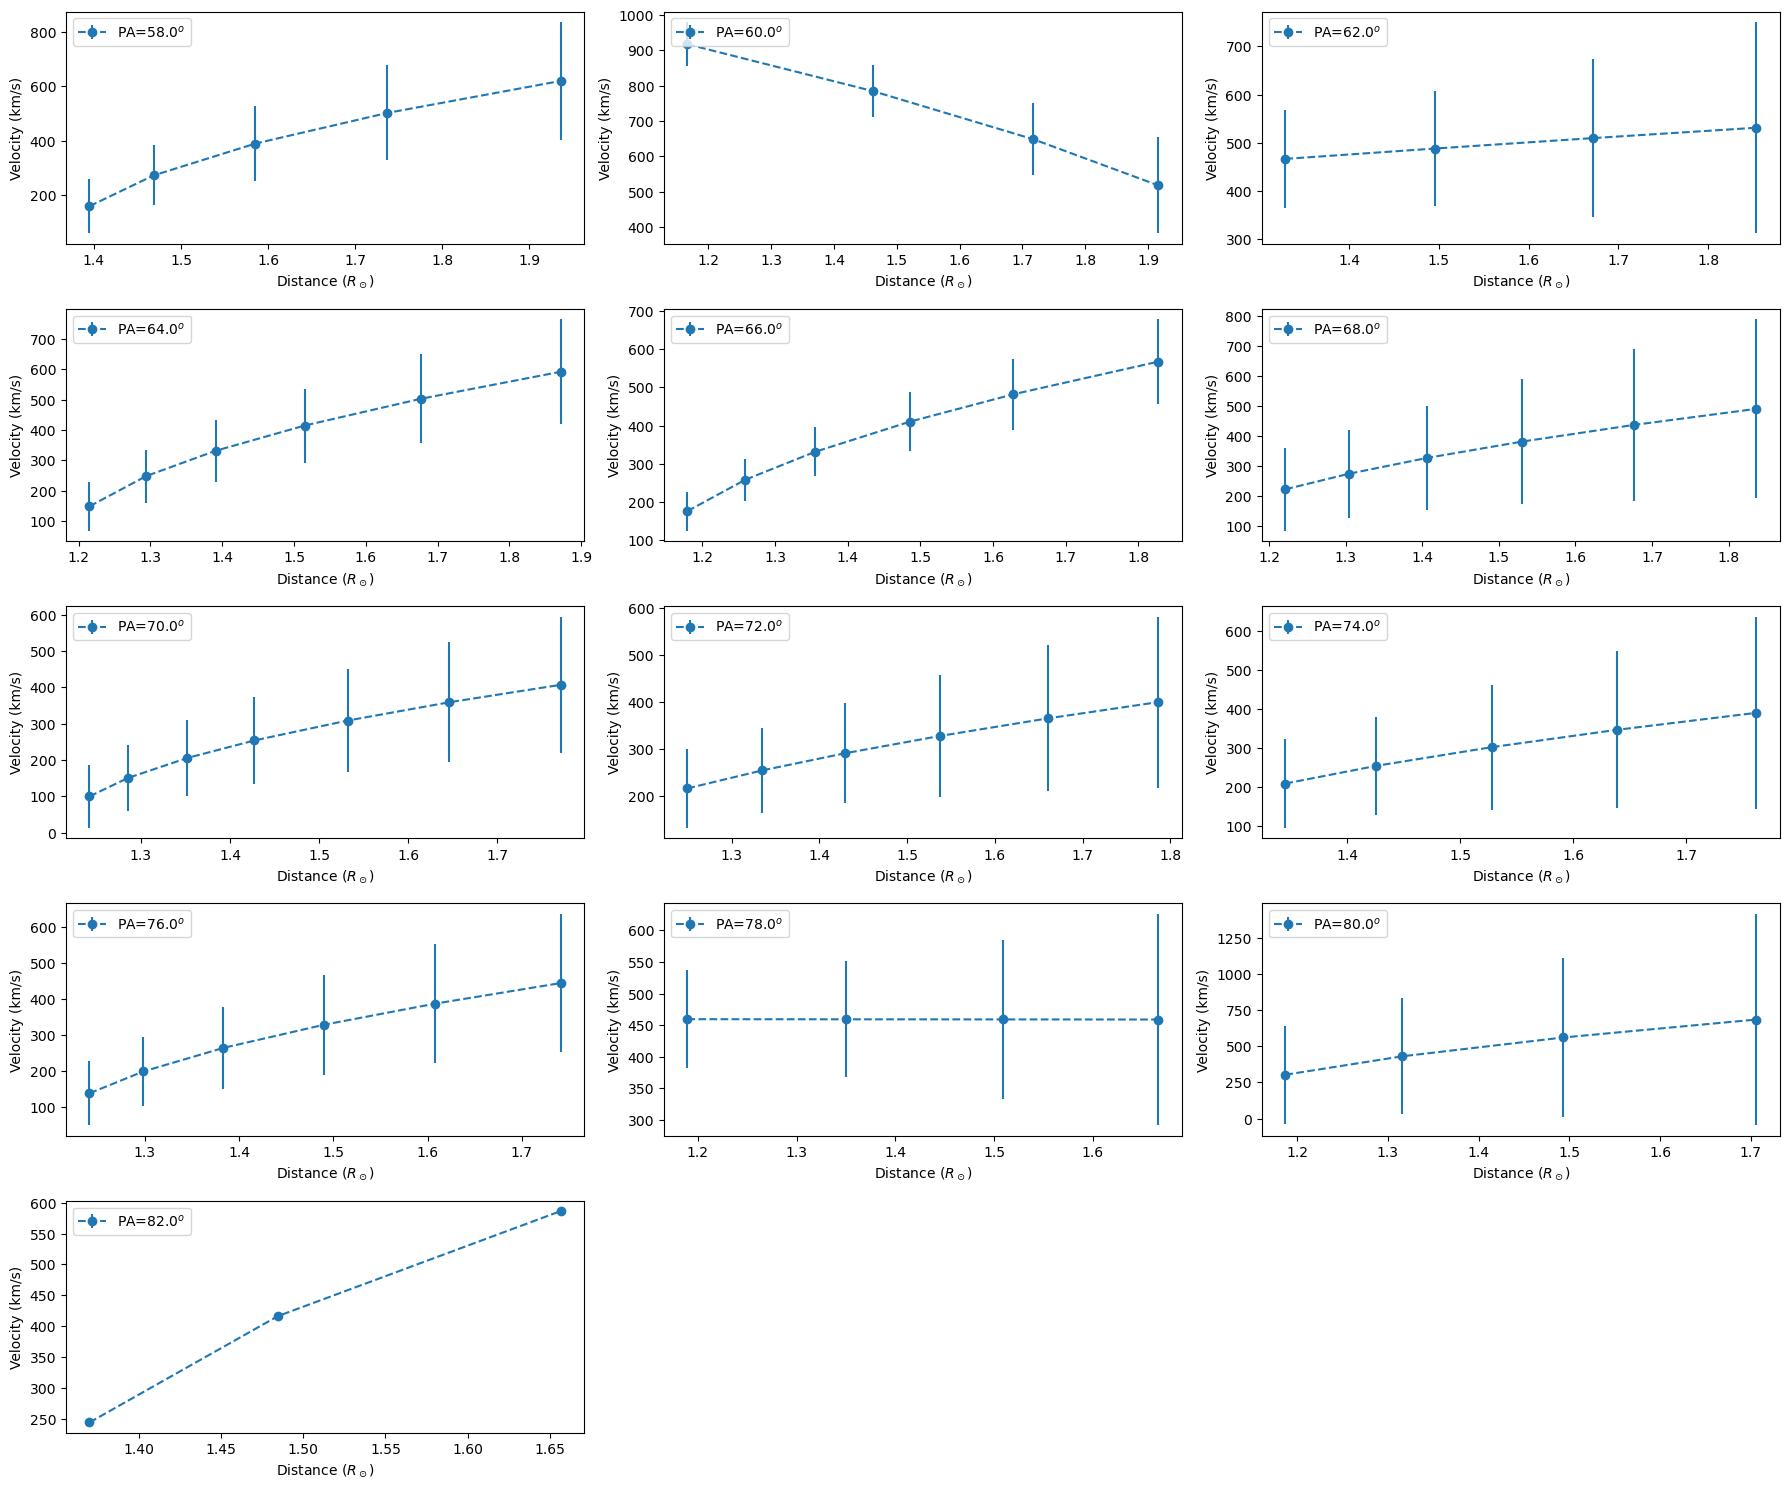

In [248]:
num_files = len(suvi_filenames)
cols = 3                                             # Number of columns in the figure
rows = (num_files // cols) + (num_files % cols > 0)  # Auto-calculate the required number of rows
bins = 10
fig, axes = plt.subplots(rows, cols, figsize=(18, 3*rows))  # Make a grid of subplots
axes = axes.flatten()  

for i, (x, y, err) in enumerate(zip(all_fit_dist_Mm_suvi, all_speeds_km_s_suvi, all_speed_errors)):
    ax = axes[i]
    x = x*u.Mm.to('solRad')
    PA_value = fit_df_suvi['PA'][i]
    ax.errorbar(x, y, yerr=err, fmt='--o', label=rf'PA={PA_value}$^o$')
    ax.set_ylabel('Velocity (km/s)')
    ax.set_xlabel(r'Distance ($R_\odot$)')
    ax.legend(loc='upper left')

# Hide unused subplots if `num_files` is not a multiple of `cols`
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [165]:
max_distance = max(map(np.max, all_fit_dist_Mm_suvi))
min_distance = max(map(np.min, all_fit_dist_Mm_suvi))
print(min_distance, max_distance)

970.3538726439342 1346.8096728106068


### Load PSI-MAS FORWARD maps

In [11]:
file_paths = sorted(glob.glob(f'{data_dir}/FORWARD/*.sav'))
print(*file_paths, sep='\n')

/home/mnedal/data/FORWARD/AIA_20240514_1710_193_512_rfilter.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BETA_2460559.9840394disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BMAG_2460559.9356944disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_DENS_2460559.9343750disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_PTOT_2460559.9832407disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_TEMP_2460559.9822801disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VPH_2460593.4820486disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VR_2460593.4744676disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VTH_2460593.4788194disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VX_2460593.5005556disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VY_2460593.5060301disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VZ_2460593.5081481disk.sav


In [12]:
for file in file_paths:
    if 'BMAG' in file:
        bmag = myfuncs.get_forward_map(file)
    elif 'DENS' in file:
        dens = myfuncs.get_forward_map(file)

In [14]:
# Calculate the Alfven speed map
mp        = astro_const.m_p.to(u.gram).value
valf_cm_s = bmag.data/np.sqrt(4*np.pi*mp*dens.data)
valf_km_s = valf_cm_s * 1e-5
va        = sunpy.map.Map(valf_km_s, dens.meta)

# # Calculate Alfven Mach number
# Ma_arr = vsw.data / va.data
# Ma     = sunpy.map.Map(Ma_arr, vsw.meta)

### Preview maps

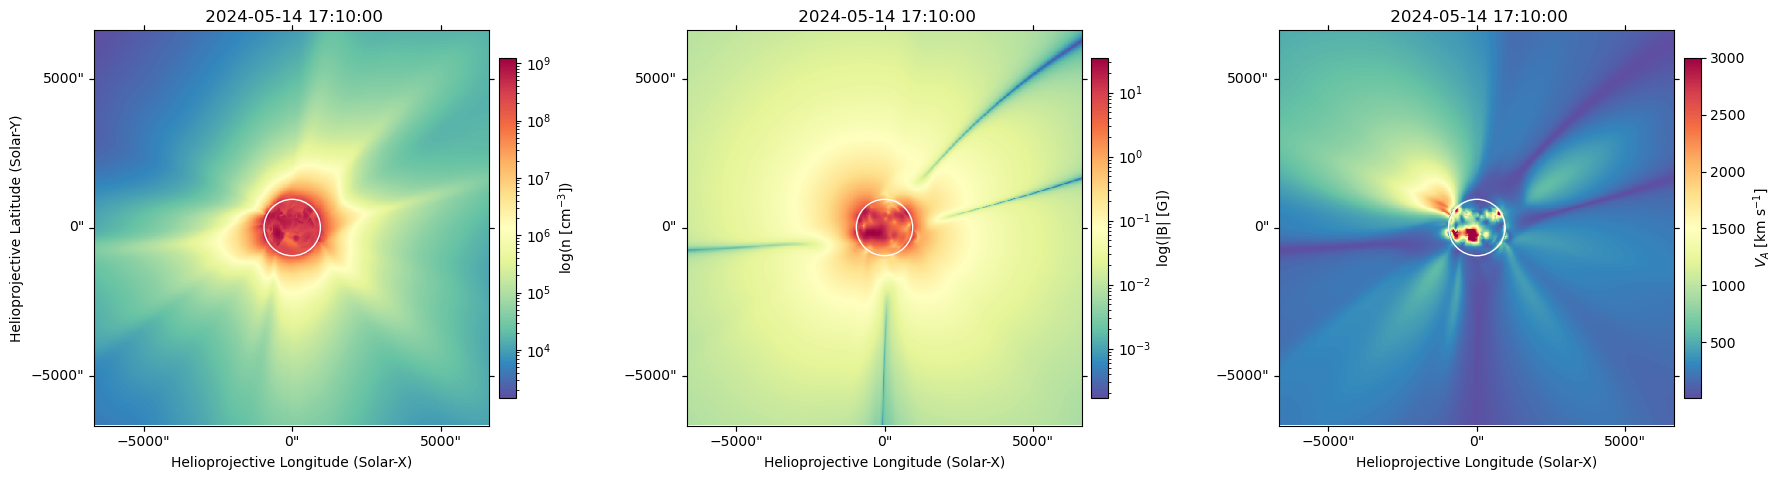

In [19]:
fig = plt.figure(figsize=[18,5])

ax  = fig.add_subplot(131, projection=dens)
img = dens.plot(axes=ax, norm=colors.LogNorm(), cmap='Spectral_r')
dens.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, shrink=0.8, pad=0.02, label=r'log(n [cm$^{-3}$])')

ax  = fig.add_subplot(132, projection=bmag)
img = bmag.plot(axes=ax, norm=colors.LogNorm(), cmap='Spectral_r')
bmag.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, shrink=0.8, pad=0.02, label='log(|B| [G])')
ax.set_ylabel(' ')

ax  = fig.add_subplot(133, projection=va)
img = va.plot(axes=ax, vmin=1e1, vmax=3e3, cmap='Spectral_r')
va.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, shrink=0.8, pad=0.02, label=r'$V_A$ [km s$^{-1}$]')
ax.set_ylabel(' ')

fig.tight_layout()
plt.show()

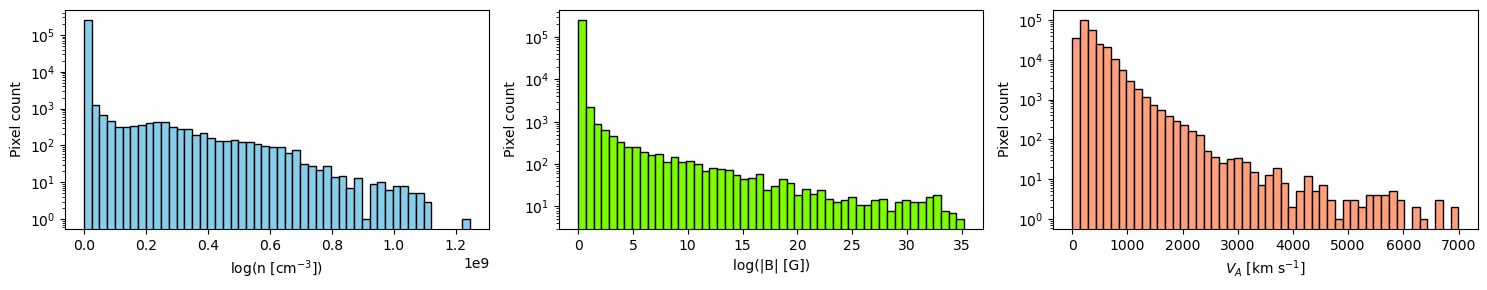

In [30]:
dens_data = dens.data.flatten()
bmag_data = bmag.data.flatten()
va_data   = va.data.flatten()

fig = plt.figure(figsize=[15,3])

ax  = fig.add_subplot(131)
ax.hist(dens_data, bins=50, log=False, color='skyblue', edgecolor='k')
ax.set_ylabel('Pixel count')
ax.set_xlabel(r'log(n [cm$^{-3}$])')
ax.set_yscale('log')
ax.grid(False)

ax  = fig.add_subplot(132)
ax.hist(bmag_data, bins=50, log=False, color='lawngreen', edgecolor='k')
ax.set_ylabel('Pixel count')
ax.set_xlabel('log(|B| [G])')
ax.set_yscale('log')
ax.grid(False)

ax  = fig.add_subplot(133)
ax.hist(va_data, bins=50, log=False, color='lightsalmon', edgecolor='k')
ax.set_ylabel('Pixel count')
ax.set_xlabel(r'$V_A$ [km s$^{-1}$]')
ax.set_yscale('log')
ax.grid(False)

fig.tight_layout()
plt.show()

In [46]:
print(f'Dimensions of SUVI map: {m.dimensions}\nVA map: {va.dimensions}')
print(f'Difference: {m.dimensions.x/va.dimensions.x}')

Dimensions of SUVI map: PixelPair(x=<Quantity 1280. pix>, y=<Quantity 1280. pix>)
VA map: PixelPair(x=<Quantity 512. pix>, y=<Quantity 512. pix>)
Difference: 2.5


### Trace Alfven speed along the slits

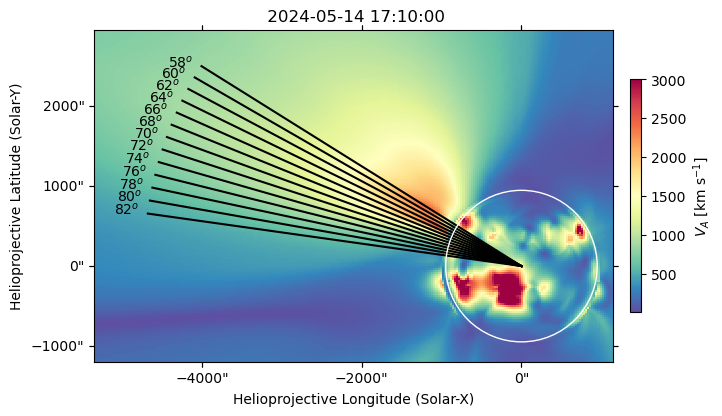

In [63]:
fig = plt.figure(figsize=[10,8])
ax  = fig.add_subplot(projection=va)
img = va.plot(axes=ax, vmin=1e1, vmax=3e3, cmap='Spectral_r')
va.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.02, label=r'$V_A$ [km s$^{-1}$]')

sampled_va   = []
sampled_dist = []

for value in centered_list:
    line = myfuncs.plot_line(angle_deg=value, length=4725, map_obj=va)
    ax.plot_coord(line, color='black')
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = va.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=va.coordinate_frame))
    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax.text(end_point_pixel.x.value-10, end_point_pixel.y.value+2, rf'{PA_value}$^o$',
            color='black', fontsize=10, ha='center', va='center')

    # sample values along slits
    with SphericalScreen(va.observer_coordinate):
        traced_loop_pixelated = sunpy.map.pixelate_coord_path(va, line)
        traced_loop_distance = traced_loop_pixelated.separation(traced_loop_pixelated[0])
    vals = sunpy.map.sample_at_coords(va, traced_loop_pixelated)
    sampled_va.append(vals)
    sampled_dist.append(traced_loop_distance.to('arcsec'))

ax.set_xlim(left=50, right=300)
ax.set_ylim(bottom=210, top=370)
fig.tight_layout()
plt.show()

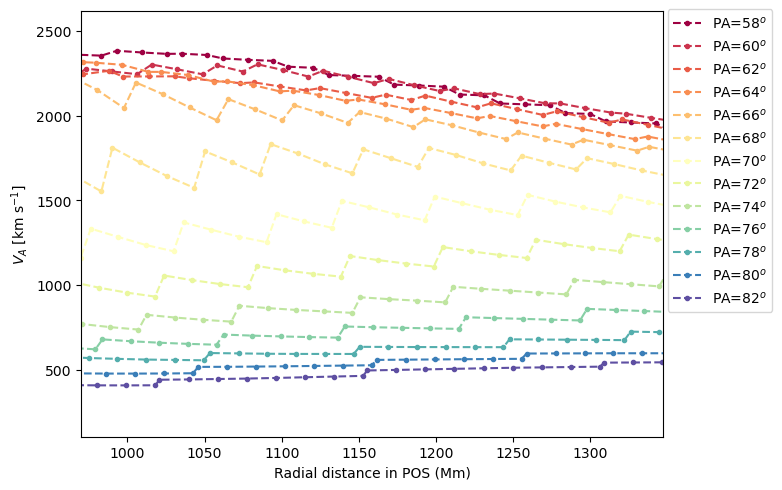

In [168]:
fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Choose a colormap with many distinguishable colors
cmap           = plt.cm.get_cmap('Spectral')
num_lines      = len(sampled_va)
colors_list    = cmap(np.linspace(0, 1, num_lines))

for i in range(len(sampled_va)):
    # rename the angles to be position angles, instead of geometric angles
    PA_value = centered_list[i] - 90
    # convert the distance from Rsun to Mm
    dist_Rs = np.array(sampled_dist[i])/va.rsun_obs.value
    dist_Rs = dist_Rs*u.solRad
    dist_Mm = dist_Rs.to('Mm')
    ax.plot(dist_Mm, sampled_va[i],
            'o--', ms=3, color=colors_list[i], label=rf'PA={PA_value}$^o$')

ax.grid(False)
ax.legend(loc='upper right', bbox_to_anchor=[1.2,1.02])
ax.set_xlabel('Radial distance in POS (Mm)')
ax.set_ylabel(r'$V_A$ [km s$^{-1}$]')
ax.set_xlim(left=970, right=1347) # min & max dist in SUVI fits
fig.tight_layout()
plt.show()

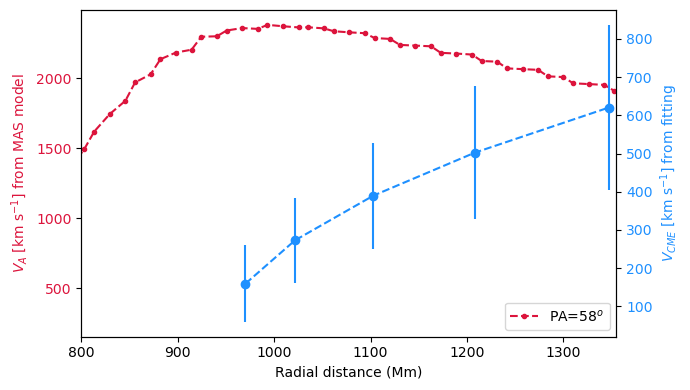

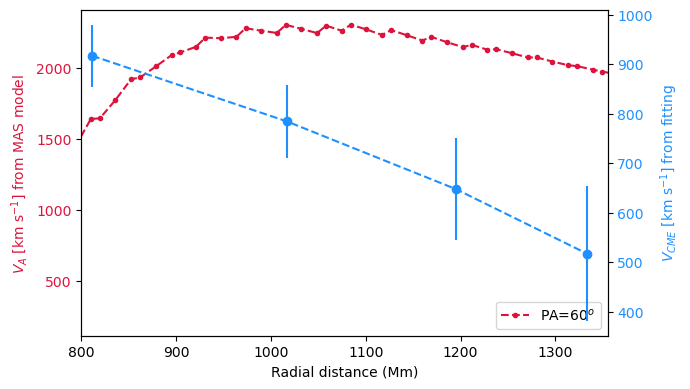

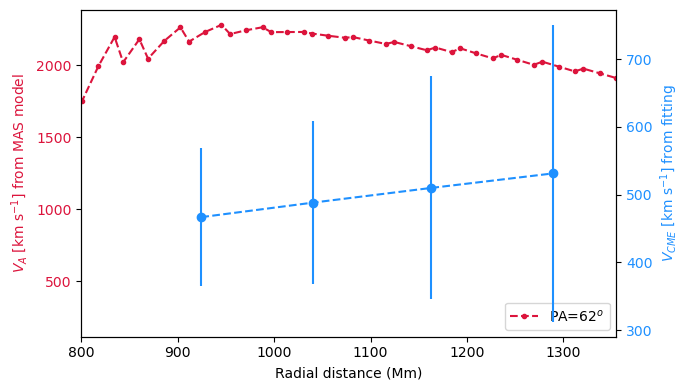

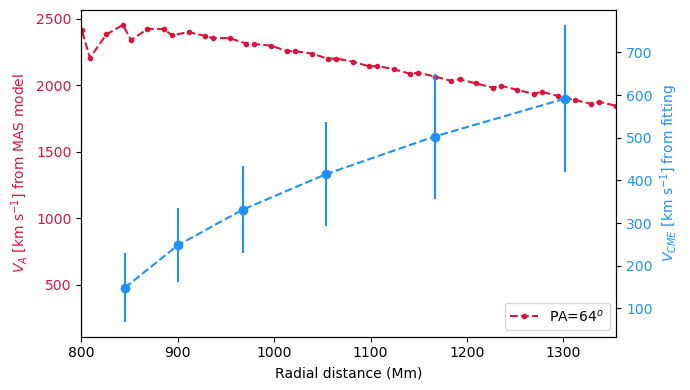

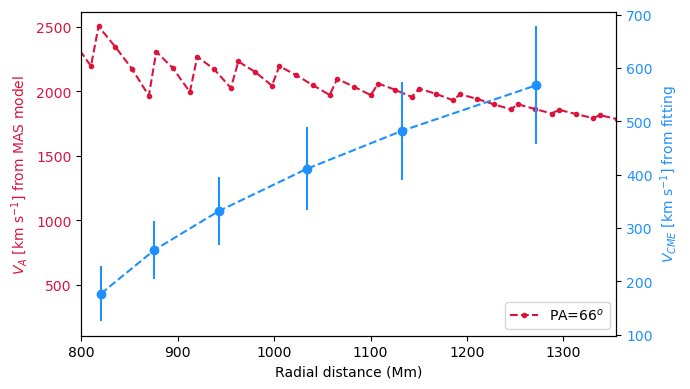

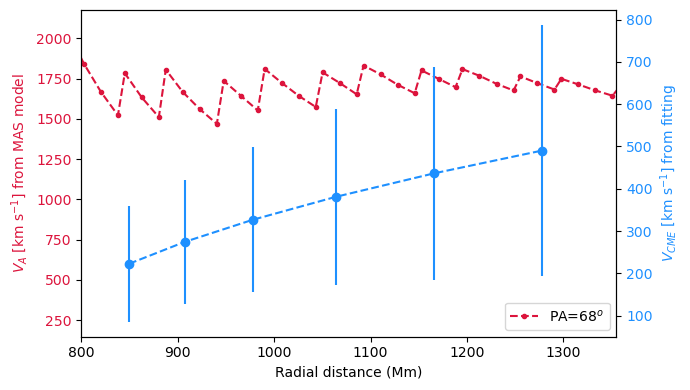

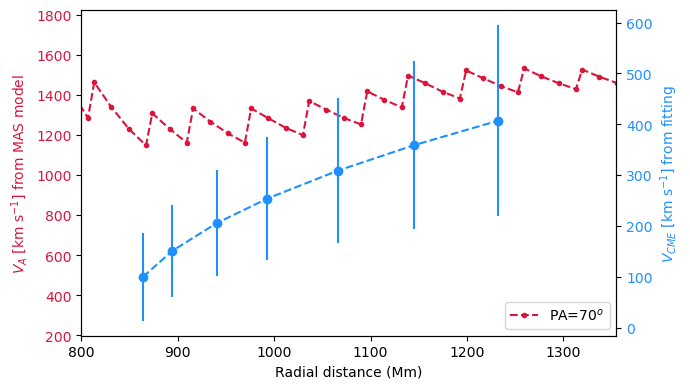

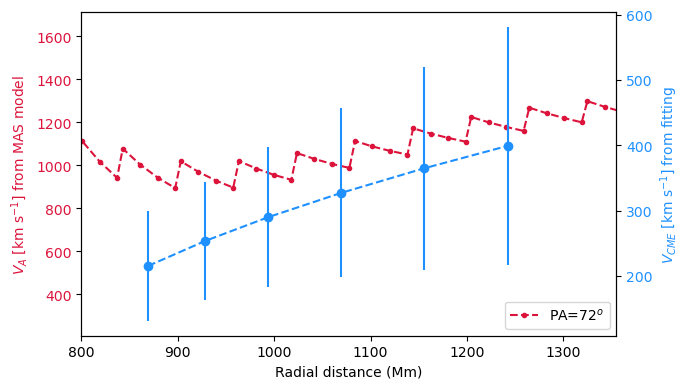

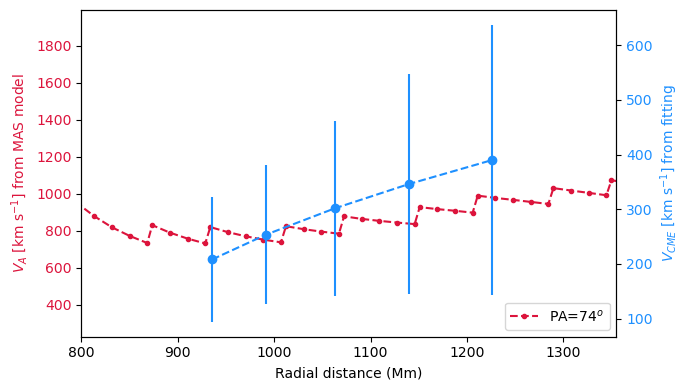

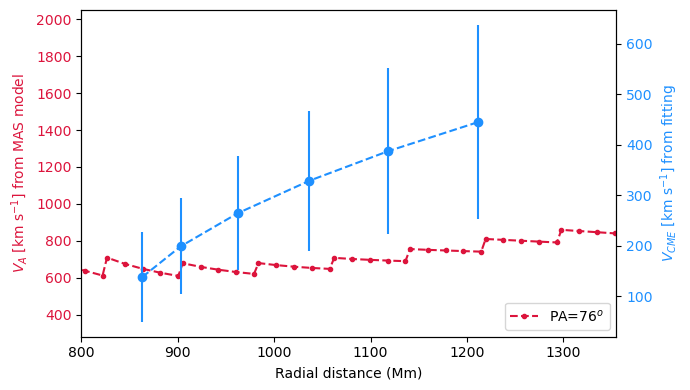

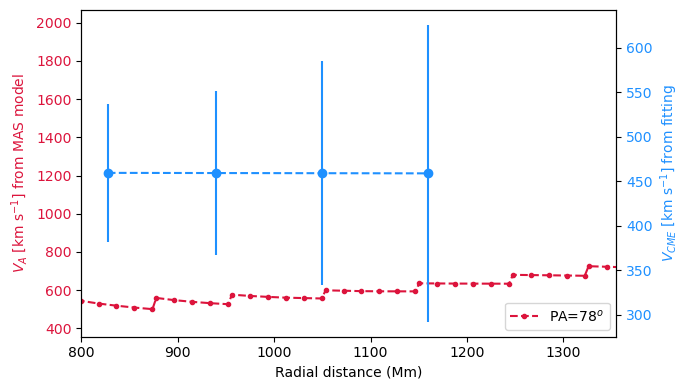

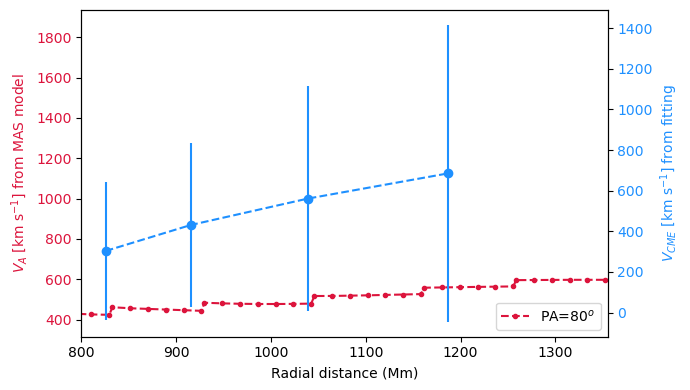

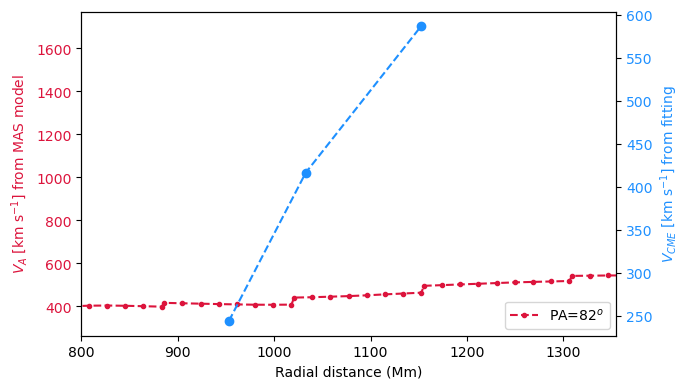

In [221]:
for i in range(len(centered_list)):
    fig = plt.figure(figsize=[7,4])
    ax  = fig.add_subplot(111)
    # rename the angles to be position angles, instead of geometric angles
    PA_value = centered_list[i] - 90
    # convert the distance from Rsun to Mm
    dist_Rs = np.array(sampled_dist[i])/va.rsun_obs.value
    dist_Rs = dist_Rs*u.solRad
    dist_Mm = dist_Rs.to('Mm')
    ax.plot(dist_Mm, sampled_va[i], 'o--', ms=3, c='crimson', label=rf'PA={PA_value}$^o$')
    ax2 = ax.twinx()
    x   = all_fit_dist_Mm_suvi[i]
    y   = all_speeds_km_s_suvi[i]
    err = all_speed_errors[i]
    ax2.errorbar(x, y, yerr=err, fmt='--o', c='dodgerblue', label='Fit distance')
    ax2.set_ylabel(r'$V_{CME}$ [km s$^{-1}$] from fitting', c='dodgerblue')
    ax.tick_params(axis='y', labelcolor='crimson')
    ax2.tick_params(axis='y', labelcolor='dodgerblue')    
    ax.grid(False)
    ax.legend(loc='lower right')
    ax.set_xlabel('Radial distance (Mm)')
    ax.set_ylabel(r'$V_A$ [km s$^{-1}$] from MAS model', c='crimson')
    ax.set_xlim(left=800, right=1355) # min & max dist in SUVI fits
    fig.tight_layout()
    plt.show()

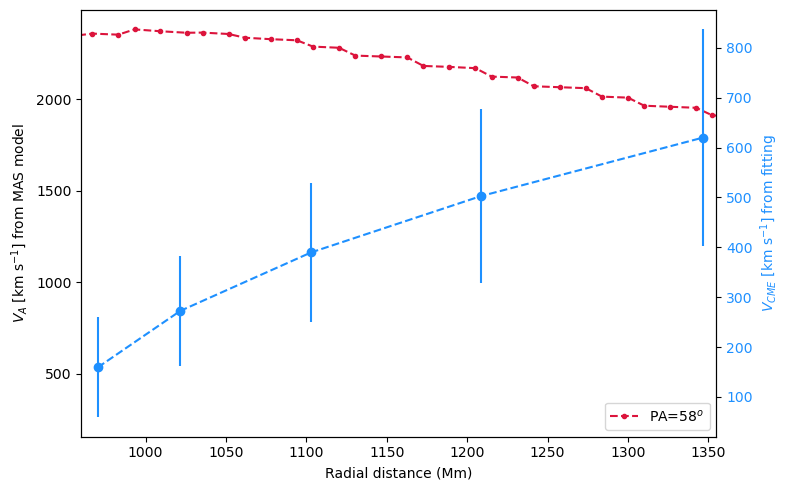

In [188]:
# Test ...
i = 0
fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)
# rename the angles to be position angles, instead of geometric angles
PA_value = centered_list[i] - 90
# convert the distance from Rsun to Mm
dist_Rs = np.array(sampled_dist[i])/va.rsun_obs.value
dist_Rs = dist_Rs*u.solRad
dist_Mm = dist_Rs.to('Mm')
ax.plot(dist_Mm, sampled_va[i], 'o--', ms=3, c='crimson', label=rf'PA={PA_value}$^o$')

ax2 = ax.twinx()
x   = all_fit_dist_Mm_suvi[i]
y   = all_speeds_km_s_suvi[i]
err = all_speed_errors[i]
ax2.errorbar(x, y, yerr=err, fmt='--o', c='dodgerblue', label='Fit distance')
ax2.set_ylabel(r'$V_{CME}$ [km s$^{-1}$] from fitting', c='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')

ax.grid(False)
ax.legend(loc='lower right')
ax.set_xlabel('Radial distance (Mm)')
ax.set_ylabel(r'$V_A$ [km s$^{-1}$] from MAS model')
ax.set_xlim(left=960, right=1355) # min & max dist in SUVI fits
fig.tight_layout()
plt.show()

In [ ]:
from scipy.interpolate import interp1d

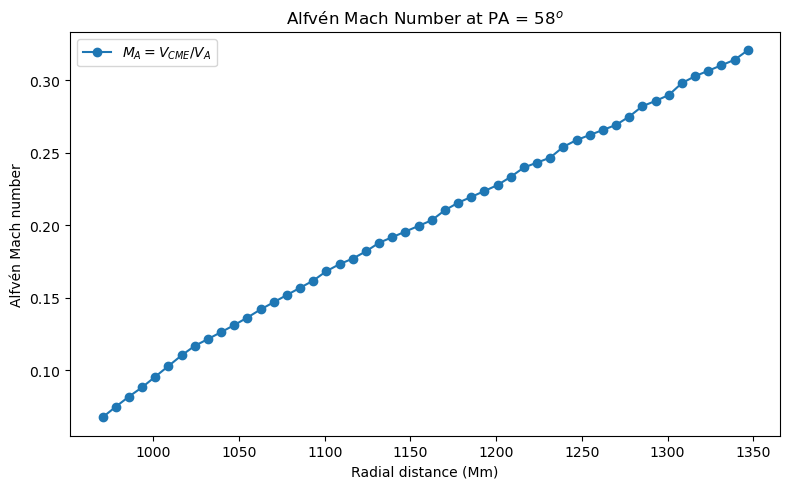

In [216]:
# Get x and y from your data
x = all_fit_dist_Mm_suvi[i]
y = all_speeds_km_s_suvi[i]

# Reference distances and VA values
dist_va = dist_Mm.value  # Alfvén speed distances
va_vals = sampled_va[i]

# Define the common distances based on x's range
common_dist = np.linspace(x.min(), x.max(), num=50)

# Interpolation functions (bounded, no extrapolation)
va_interp_func   = interp1d(dist_va, va_vals, kind='linear', bounds_error=False, fill_value=np.nan)
vcme_interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)

# Interpolate
va_interp   = va_interp_func(common_dist)
vcme_interp = vcme_interp_func(common_dist)

# Calculate Mach number (avoid divide-by-zero or NaNs)
with np.errstate(divide='ignore', invalid='ignore'):
    mach_number = vcme_interp / va_interp
    mach_number = np.where(np.isfinite(mach_number), mach_number, np.nan)

# Plot the result
plt.figure(figsize=[8,5])
plt.plot(common_dist, mach_number, '-o', label=r'$M_A = V_{CME} / V_A$')
plt.xlabel('Radial distance (Mm)')
plt.ylabel('Alfvén Mach number')
plt.grid(False)
plt.legend()
plt.title(rf'Alfvén Mach Number at PA = {PA_value}$^o$')
plt.tight_layout()
plt.show()

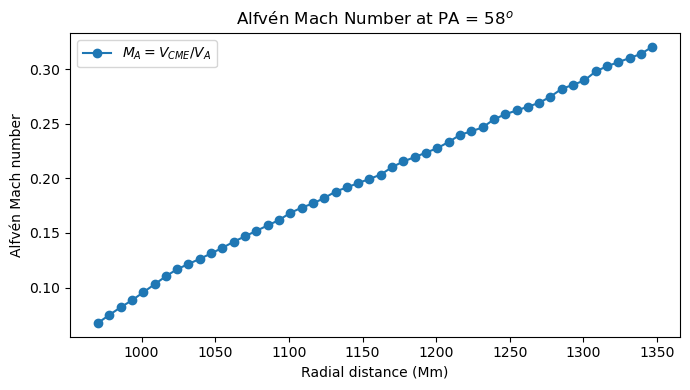

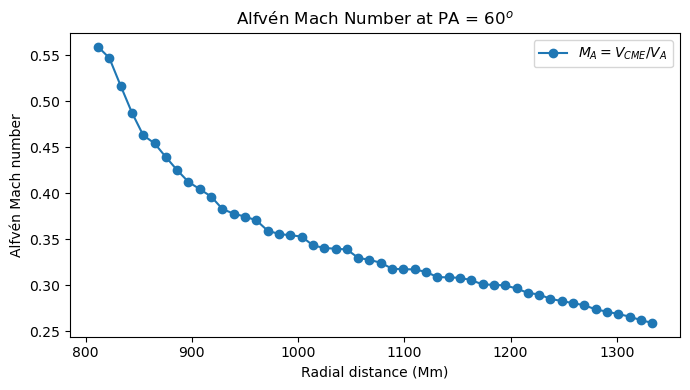

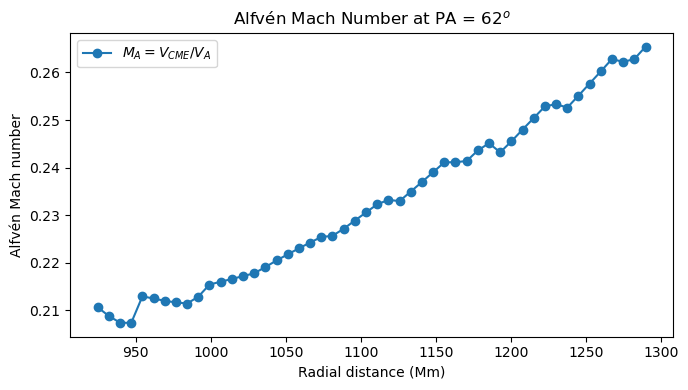

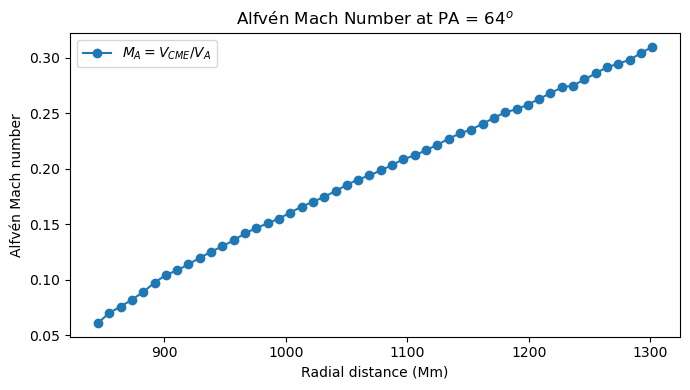

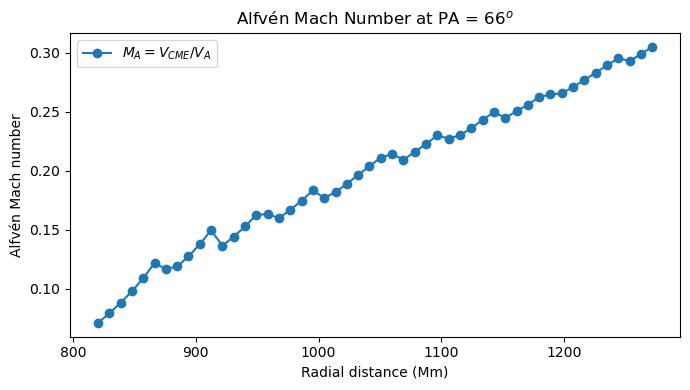

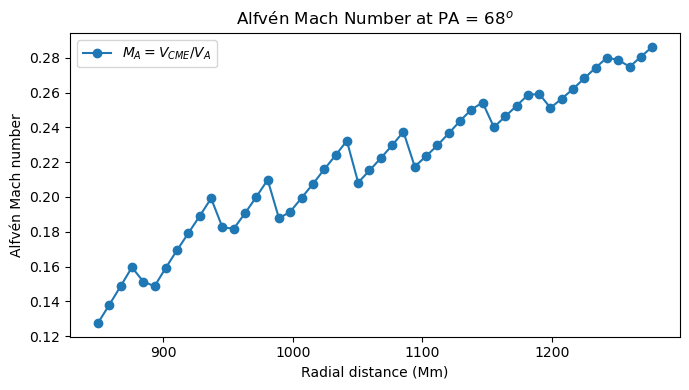

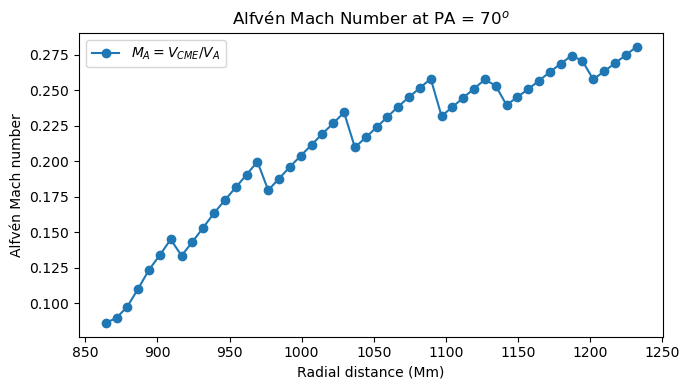

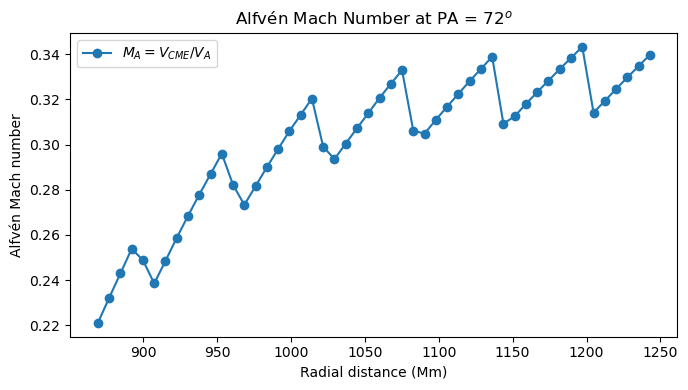

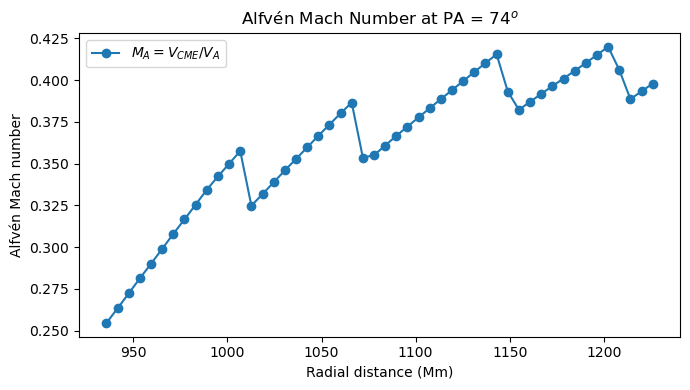

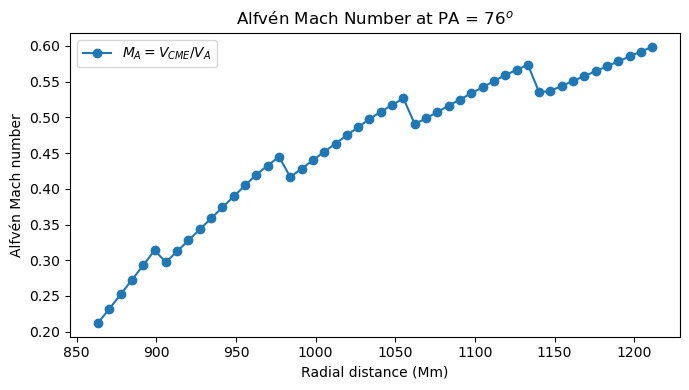

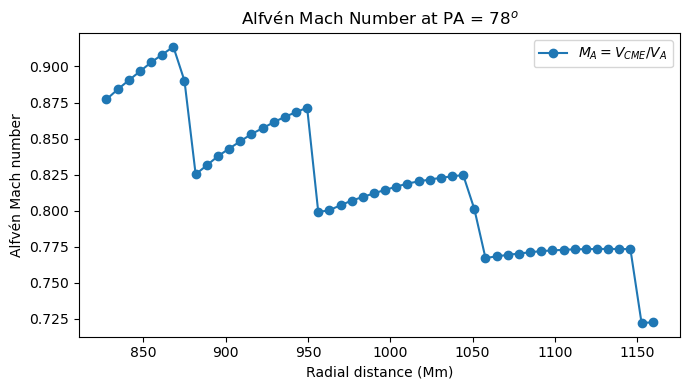

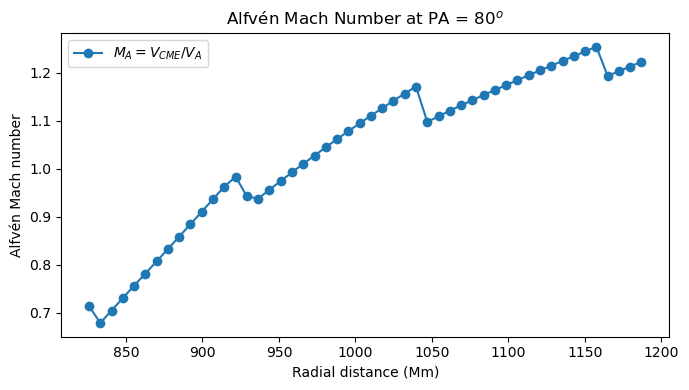

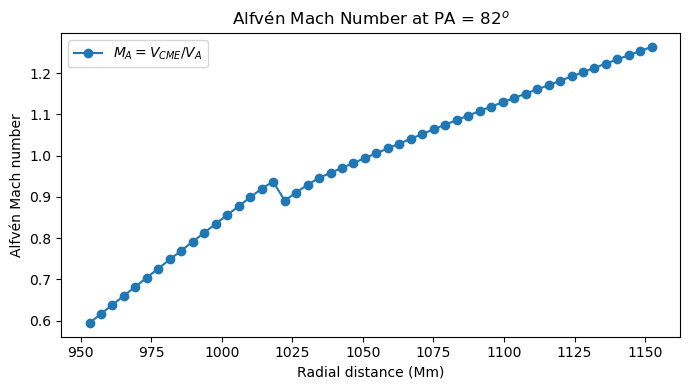

In [223]:
for i in range(len(centered_list)):
    # rename the angles to be position angles, instead of geometric angles
    PA_value = centered_list[i] - 90
    
    # Get x and y from your data
    x = all_fit_dist_Mm_suvi[i]
    y = all_speeds_km_s_suvi[i]
    
    # convert the distance from Rsun to Mm
    dist_Rs = np.array(sampled_dist[i])/va.rsun_obs.value
    dist_Rs = dist_Rs*u.solRad
    dist_Mm = dist_Rs.to('Mm')
    
    # Reference distances and VA values
    dist_va = dist_Mm.value  # Alfvén speed distances
    va_vals = sampled_va[i]
    
    # Define the common distances based on x's range
    common_dist = np.linspace(x.min(), x.max(), num=50)
    
    # Interpolation functions (bounded, no extrapolation)
    va_interp_func   = interp1d(dist_va, va_vals, kind='linear', bounds_error=False, fill_value=np.nan)
    vcme_interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    
    # Interpolate
    va_interp   = va_interp_func(common_dist)
    vcme_interp = vcme_interp_func(common_dist)
    
    # Calculate Mach number (avoid divide-by-zero or NaNs)
    with np.errstate(divide='ignore', invalid='ignore'):
        mach_number = vcme_interp / va_interp
        mach_number = np.where(np.isfinite(mach_number), mach_number, np.nan)
    
    # Plot the result
    plt.figure(figsize=[7,4])
    plt.plot(common_dist, mach_number, '-o', label=r'$M_A = V_{CME} / V_A$')
    plt.xlabel('Radial distance (Mm)')
    plt.ylabel('Alfvén Mach number')
    plt.grid(False)
    plt.legend()
    plt.title(rf'Alfvén Mach Number at PA = {PA_value}$^o$')
    plt.tight_layout()
    plt.show()

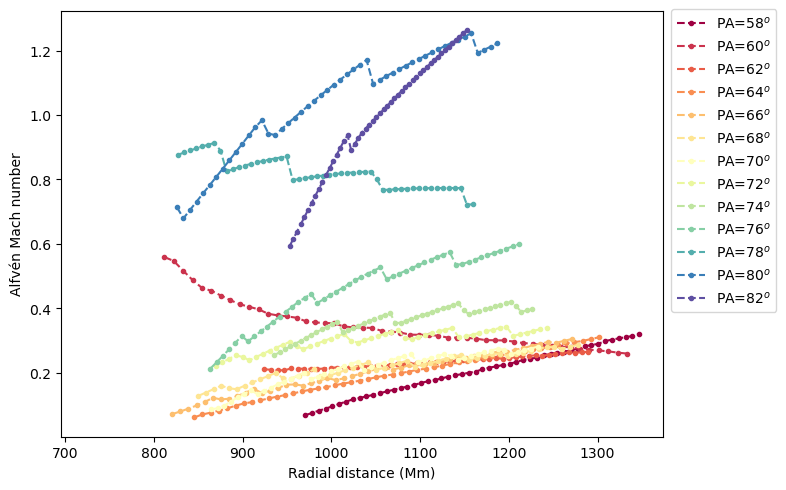

In [239]:
# all in one plot
fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Choose a colormap with many distinguishable colors
cmap           = plt.cm.get_cmap('Spectral')
num_lines      = len(centered_list)
colors_list    = cmap(np.linspace(0, 1, num_lines))

for i in range(num_lines):
    # rename the angles to be position angles, instead of geometric angles
    PA_value = centered_list[i] - 90
    
    # Get x and y from your data
    x = all_fit_dist_Mm_suvi[i]
    y = all_speeds_km_s_suvi[i]
    
    # convert the distance from Rsun to Mm
    dist_Rs = np.array(sampled_dist[i])/va.rsun_obs.value
    dist_Rs = dist_Rs*u.solRad
    dist_Mm = dist_Rs.to('Mm')
    
    # Reference distances and VA values
    dist_va = dist_Mm.value  # Alfvén speed distances
    va_vals = sampled_va[i]
    
    # Define the common distances based on x's range
    common_dist = np.linspace(x.min(), x.max(), num=50)
    
    # Interpolation functions (bounded, no extrapolation)
    va_interp_func   = interp1d(dist_va, va_vals, kind='linear', bounds_error=False, fill_value=np.nan)
    vcme_interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    
    # Interpolate
    va_interp   = va_interp_func(common_dist)
    vcme_interp = vcme_interp_func(common_dist)
    
    # Calculate Mach number (avoid divide-by-zero or NaNs)
    with np.errstate(divide='ignore', invalid='ignore'):
        mach_number = vcme_interp / va_interp
        mach_number = np.where(np.isfinite(mach_number), mach_number, np.nan)
    
    ax.plot(common_dist, mach_number, 'o--', ms=3, color=colors_list[i], label=rf'PA={PA_value}$^o$')

ax.set_xlabel('Radial distance (Mm)')
ax.set_ylabel('Alfvén Mach number')
ax.grid(False)
ax.legend(loc='upper right', bbox_to_anchor=[1.2,1.02])
ax.set_xlim(left=1*u.solRad.to('Mm'))
fig.tight_layout()
plt.show()

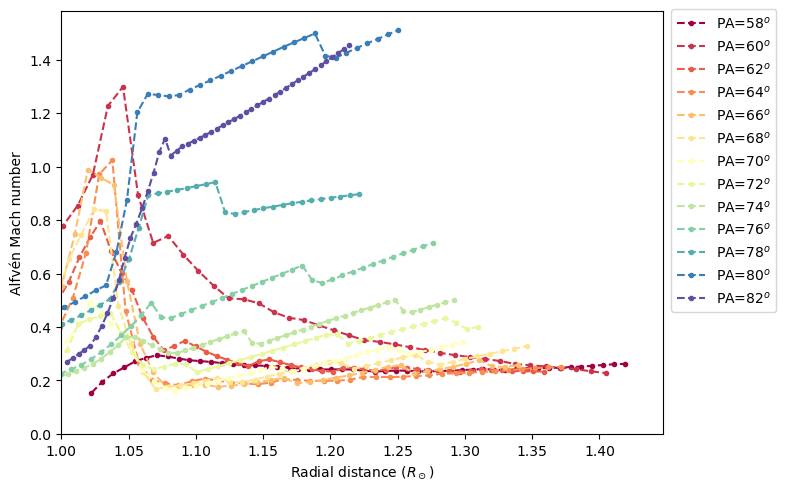

In [242]:
# all in one plot
fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)

# Choose a colormap with many distinguishable colors
cmap           = plt.cm.get_cmap('Spectral')
num_lines      = len(centered_list)
colors_list    = cmap(np.linspace(0, 1, num_lines))

for i in range(num_lines):
    # rename the angles to be position angles, instead of geometric angles
    PA_value = centered_list[i] - 90
    
    # Get x and y from your data
    x = all_fit_dist_Mm_suvi[i]/m.rsun_obs.value
    y = all_speeds_km_s_suvi[i]
    
    # convert the VA distance from Rsun to Mm
    dist_Rs = np.array(sampled_dist[i])/va.rsun_obs.value
    dist_Rs = dist_Rs*u.solRad
    
    # Reference distances and VA values
    dist_va = dist_Rs.value  # Alfvén speed distances
    va_vals = sampled_va[i]
    
    # Define the common distances based on x's range
    common_dist = np.linspace(x.min(), x.max(), num=50)
    
    # Interpolation functions (bounded, no extrapolation)
    va_interp_func   = interp1d(dist_va, va_vals, kind='linear', bounds_error=False, fill_value=np.nan)
    vcme_interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    
    # Interpolate
    va_interp   = va_interp_func(common_dist)
    vcme_interp = vcme_interp_func(common_dist)
    
    # Calculate Mach number (avoid divide-by-zero or NaNs)
    with np.errstate(divide='ignore', invalid='ignore'):
        mach_number = vcme_interp / va_interp
        mach_number = np.where(np.isfinite(mach_number), mach_number, np.nan)
    
    ax.plot(common_dist, mach_number, 'o--', ms=3, color=colors_list[i], label=rf'PA={PA_value}$^o$')

ax.set_xlabel(r'Radial distance ($R_\odot$)')
ax.set_ylabel('Alfvén Mach number')
ax.grid(False)
ax.legend(loc='upper right', bbox_to_anchor=[1.2,1.02])
ax.set_xlim(left=1)
fig.tight_layout()
plt.show()

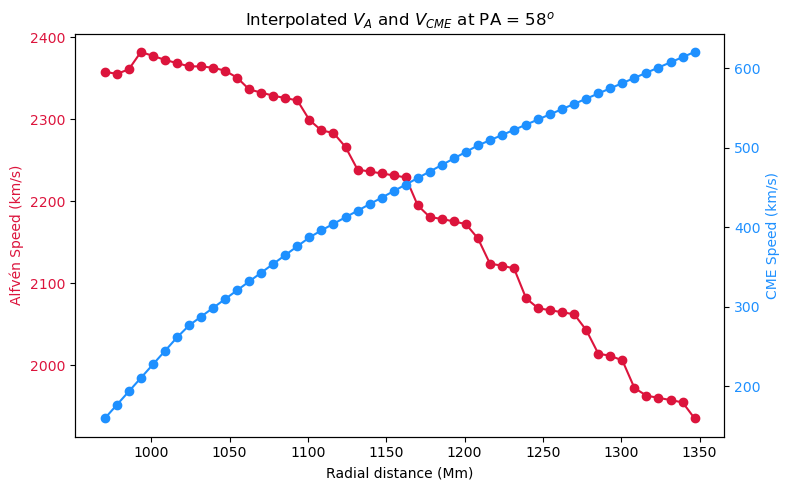

In [217]:
# Sanity check ...
fig = plt.figure(figsize=[8,5])
ax  = fig.add_subplot(111)
ax.plot(common_dist, va_interp, '-o', c='crimson')
ax2 = ax.twinx()
ax2.plot(common_dist, vcme_interp, '-o', c='dodgerblue')
ax.set_xlabel('Radial distance (Mm)')
ax.set_ylabel('Alfvén Speed (km/s)', c='crimson')
ax2.set_ylabel('CME Speed (km/s)', c='dodgerblue')
ax.tick_params(axis='y', labelcolor='crimson')
ax2.tick_params(axis='y', labelcolor='dodgerblue')
ax.grid(False)
ax.set_title(rf'Interpolated $V_A$ and $V_{{CME}}$ at PA = {PA_value}$^o$')
fig.tight_layout()
plt.show()

In [167]:
# # Sanity check ...
# fig = plt.figure(figsize=[8,5])
# ax  = fig.add_subplot(111)

# # Choose a colormap with many distinguishable colors
# cmap           = plt.cm.get_cmap('Spectral')
# num_lines      = len(sampled_va)
# colors_list    = cmap(np.linspace(0, 1, num_lines))

# for i in range(len(sampled_va)):
#     # rename the angles to be position angles, instead of geometric angles
#     PA_value = centered_list[i] - 90
#     ax.plot(sampled_dist[i]/va.rsun_obs.value, sampled_va[i],
#             'o--', ms=3, color=colors_list[i], label=rf'PA={PA_value}$^o$')

# ax.grid(False)
# ax.legend(loc='upper right', bbox_to_anchor=[1.2,1.02])
# ax.set_xlabel(r'Radial distance in POS ($R_\odot$)')
# ax.set_ylabel(r'$V_{alfven}$ [km s$^{-1}$]')
# ax.set_xlim(left=1, right=3.2)
# fig.tight_layout()
# plt.show()

### Est. Alfvén Mach number along the slits via taking CME speed to Alfvén speed ratio (assuming $V_A$ is time invariant)

In [279]:
i = 0                        # index of PA slit
vcme_val = 100               # CME speed
va_val   = sampled_va[i]     # local background Alfven speed
vsw_val  = sampled_vsw[i]    # Parker solution to the solar wind as in Mann et al. (2002) ... from the 2D plane-of-sky map of the MAS model

MA_method2 = (vcme_val - vsw_val)/va_val

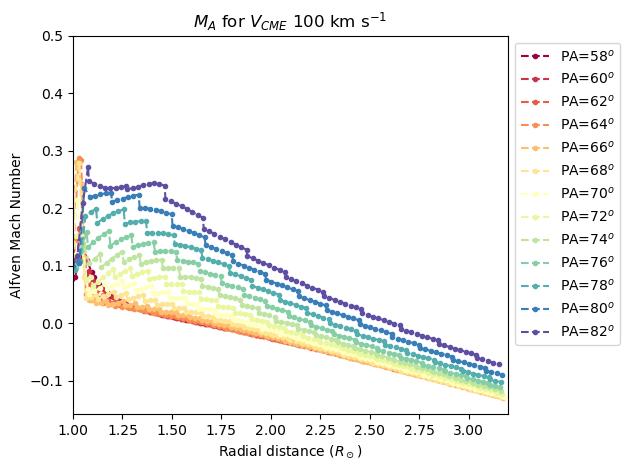

In [281]:
fig = plt.figure()
ax  = fig.add_subplot()

# Choose a colormap with many distinguishable colors
cmap           = plt.cm.get_cmap('Spectral')
num_lines      = len(sampled_va)
colors_list    = cmap(np.linspace(0, 1, num_lines))

for i in range(len(sampled_va)):
    # rename the angles to be position angles, instead of geometric angles
    PA_value = centered_list[i] - 90
    
    va_val   = sampled_va[i]     # local background Alfven speed
    vsw_val  = sampled_vsw[i]    # Parker solution to the solar wind as in Mann et al. (2002) ... from the 2D plane-of-sky map of the MAS model
    MA_method2 = (vcme_val - vsw_val)/va_val
    
    ax.plot(sampled_dist[i]/va.rsun_obs.value, MA_method2,
            'o--', ms=3, color=colors_list[i], label=rf'PA={PA_value}$^o$')

ax.grid(False)
ax.legend(bbox_to_anchor=[1, 1])
ax.set_xlabel(r'Radial distance ($R_\odot$)')
ax.set_ylabel('Alfven Mach Number')
ax.set_title(rf'$M_A$ for $V_{{CME}}$ {vcme_val} km s$^{{-1}}$')
ax.set_xlim(left=1, right=3.2)
ax.set_ylim(top=0.5)
fig.tight_layout()
plt.show()

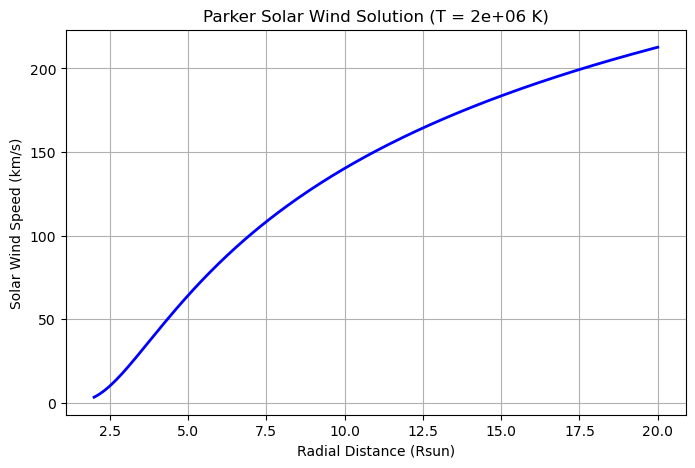

r = 2.00 Rsun, v = 3.3 km/s
r = 5.62 Rsun, v = 76.5 km/s
r = 9.24 Rsun, v = 131.5 km/s
r = 12.85 Rsun, v = 167.4 km/s
r = 16.47 Rsun, v = 193.2 km/s


In [184]:
from scipy.optimize import fsolve

def parker_solution(T, r_min=2, r_max=20, N=200):
    """
    Compute the Parker solar wind solution for an isothermal corona.
    
    Parameters:
      T    : Effective coronal temperature in Kelvin.
      r_min: Minimum radial distance in solar radii.
      r_max: Maximum radial distance in solar radii.
      N    : Number of points between r_min and r_max.
    
    Returns:
      r_vals: Radial distances in solar radii (array).
      v_vals: Solar wind speeds in km/s (array).
    """
    
    # Constants
    G = 6.67430e-11         # gravitational constant [m^3 kg^-1 s^-2]
    M_sun = 1.9885e30       # solar mass [kg]
    k_B = 1.380649e-23      # Boltzmann constant [J/K]
    m_p = 1.6726219e-27     # proton mass [kg]
    R_sun = 6.96e8          # solar radius in meters

    # Isothermal sound speed:
    c_s = np.sqrt(k_B * T / m_p)  # [m/s]
    
    # Critical radius: r_crit = GM/(2 c_s^2)
    r_crit = G * M_sun / (2 * c_s**2)
    
    # Parker equation: u^2 - ln(u^2) = 4*ln(r/r_crit) + 4*(r_crit/r) - 3, with u = v/c_s.
    def parker_equation(u, r):
        return u**2 - np.log(u**2) - (4 * np.log(r / r_crit) + 4 * (r_crit / r) - 3)
    
    def solve_u(r):
        # Use a very small initial guess if r is well below r_crit (subsonic),
        # and a larger guess when r is above r_crit (supersonic).
        if r < r_crit:
            u_guess = 1e-3
        else:
            u_guess = 2.0
        u_sol, info, ier, mesg = fsolve(parker_equation, u_guess, args=(r,), full_output=True)
        if ier != 1 or u_sol[0] <= 0:
            raise RuntimeError(f"At r = {r:.2e} m: {mesg}")
        return u_sol[0]
    
    # Create a radial grid in meters from r_min*R_sun to r_max*R_sun.
    r_vals = np.linspace(r_min * R_sun, r_max * R_sun, N)
    v_vals = np.array([solve_u(r) * c_s for r in r_vals])
    
    # Return r in solar radii and v in km/s.
    return r_vals / R_sun, v_vals / 1e3

# Choose an effective temperature. Try T = 2e6 K.
T_effective = 1.5e6  # Kelvin

r_plot, v_plot = parker_solution(T_effective, r_min=2, r_max=20, N=200)

plt.figure(figsize=(8, 5))
plt.plot(r_plot, v_plot, 'b-', lw=2)
plt.xlabel('Radial Distance (Rsun)')
plt.ylabel('Solar Wind Speed (km/s)')
plt.title(f'Parker Solar Wind Solution (T = {T_effective:.0e} K)')
plt.grid(True)
plt.show()

# Print a few sample values:
for r_val, v_val in zip(r_plot[::40], v_plot[::40]):
    print(f"r = {r_val:.2f} Rsun, v = {v_val:.1f} km/s")

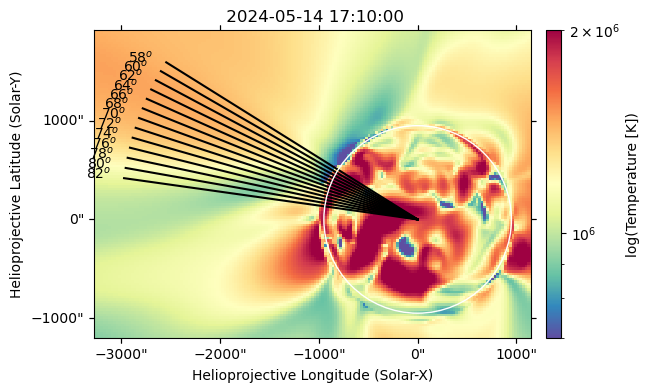

In [167]:
fig = plt.figure(figsize=[10,4])
ax  = fig.add_subplot(projection=temp)
img = temp.plot(axes=ax, norm=colors.LogNorm(vmin=7e5, vmax=2e6), cmap='Spectral_r')
temp.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='log(Temperature [K])')

sampled_temp = []
sampled_dist = []

for value in centered_list:
    line = myfuncs.plot_line(angle_deg=value, length=3000, map_obj=temp)
    ax.plot_coord(line, color='black')
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = temp.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=temp.coordinate_frame))
    # rename the angles to be position angles, instead of geometric angles
    PA_value = value - 90
    # Display the number at the end point
    ax.text(end_point_pixel.x.value-10, end_point_pixel.y.value+2, rf'{PA_value}$^o$',
            color='black', fontsize=10, ha='center', va='center')

    # sample values along slits
    with SphericalScreen(temp.observer_coordinate):
        traced_loop_pixelated = sunpy.map.pixelate_coord_path(temp, line)
        traced_loop_distance = traced_loop_pixelated.separation(traced_loop_pixelated[0])
    vals = sunpy.map.sample_at_coords(temp, traced_loop_pixelated)
    sampled_temp.append(vals)
    sampled_dist.append(traced_loop_distance.to('arcsec'))

ax.set_xlim(left=130, right=300)
ax.set_ylim(bottom=210, top=330)
fig.tight_layout()
plt.show()

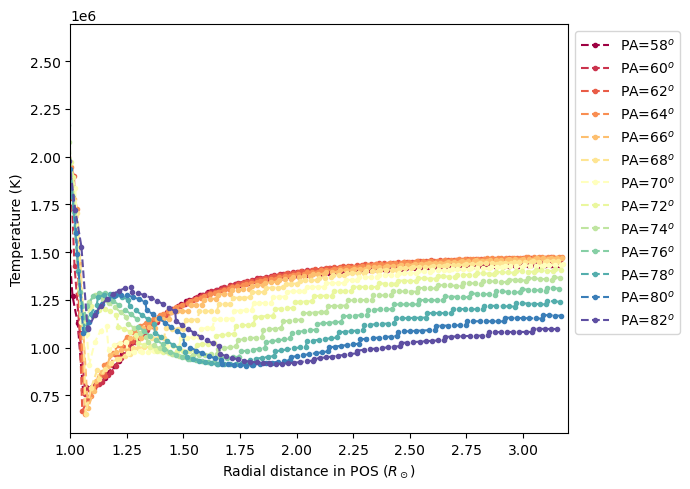

In [173]:
fig = plt.figure(figsize=[7,5])
ax  = fig.add_subplot(111)

# Choose a colormap with many distinguishable colors
cmap           = plt.cm.get_cmap('Spectral')
num_lines      = len(sampled_temp)
colors_list    = cmap(np.linspace(0, 1, num_lines))

for i in range(len(sampled_temp)):
    # rename the angles to be position angles, instead of geometric angles
    PA_value = centered_list[i] - 90
    ax.plot(sampled_dist[i]/temp.rsun_obs.value, sampled_temp[i],
            'o--', ms=3, color=colors_list[i], label=rf'PA={PA_value}$^o$')

ax.grid(False)
ax.legend(bbox_to_anchor=[1, 1])
ax.set_xlabel(r'Radial distance in POS ($R_\odot$)')
ax.set_ylabel('Temperature (K)')
ax.set_xlim(left=1, right=3.2)
fig.tight_layout()
plt.show()

In [182]:
for val in mean_per_array:
    print(f'{val:.2e}')

1.46e+06
1.48e+06
1.49e+06
1.49e+06
1.49e+06
1.47e+06
1.46e+06
1.43e+06
1.40e+06
1.37e+06
1.34e+06
1.31e+06
1.29e+06


Method 3: Band-splitting

In [ ]:
BDW  = df/f                # relative instantaneous bandwidth, from the I-LOFAR dynamic spectra
X    = (BDW + 1)**2        # compression ratio
beta = ...                 # plasma-to-magnetic pressure ratio, from the 2D plane-of-sky map of the MAS model

MA_method3 = np.sqrt( X*(X + 5 + 5*beta) / 2*(4 - X) ) # for a quasi-perpendicular shock, from Vršnak et al. (2002)

Comparison